In [1]:
from BiasStudy import datasets, predictionKit

Python Platform: Linux-5.19.0-45-generic-x86_64-with-glibc2.35
Tensor Flow Version: 2.12.1
Keras Version: 2.12.0

Python 3.8.19 (default, Apr  6 2024, 17:58:10) 
[GCC 11.4.0]


In [2]:
import os
import sys
import platform
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
BASE_DIR = "/notebooks/data/LFWA+/COMPILED"
IMAGE_DIR = "/notebooks/data/LFWA+/COMPILED/compiled_lfwa+"
LIGH_PAIRS = "compiled_lfwa+_light_pairs.csv"
DARK_PAIRS = "compiled_lfwa+_dark_pairs.csv"
ALL_PAIRS = "compiled_lfwa+_all_pairs.csv"

In [5]:
all_pairs =  pd.read_csv("{}/{}".format(BASE_DIR, ALL_PAIRS))

In [6]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG16

In [7]:
vgg16_model_base = VGG16(weights='imagenet', input_shape=(224, 224, 3))

# set VGG to be frozen
for layer in vgg16_model_base.layers:
    layer.trainable = False

553467096/553467096 [==============================] - 4s 0us/step


In [8]:
print(vgg16_model_base.get_compile_config())

None


In [9]:
vgg16_model = Model(
    inputs = vgg16_model_base.input, 
    outputs = vgg16_model_base.get_layer('fc2').output,
    name = "VGG16"
)

In [10]:
vgg19_model_base = VGG19(weights='imagenet', input_shape=(224, 224, 3))

# set VGG to be frozen
for layer in vgg19_model_base.layers:
    layer.trainable = False

574710816/574710816 [==============================] - 4s 0us/step


In [11]:
vgg19_model = Model(
    inputs = vgg19_model_base.input, 
    outputs = vgg19_model_base.get_layer('fc2').output,
    name = "VGG19"
)

In [13]:
from BiasStudy.predictionKit import PredictionToolKit

In [14]:
vgg16_prediction_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = vgg16_model,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [15]:
vgg19_prediction_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = vgg19_model,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [16]:
print(vgg16_prediction_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 48.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.538990996815646 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.660708977407848 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.327586206896552 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.120689655172414 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 24.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.538990996815646 |
+-------

In [17]:
from BiasStudy.predictionKit import PredictionPlotKit

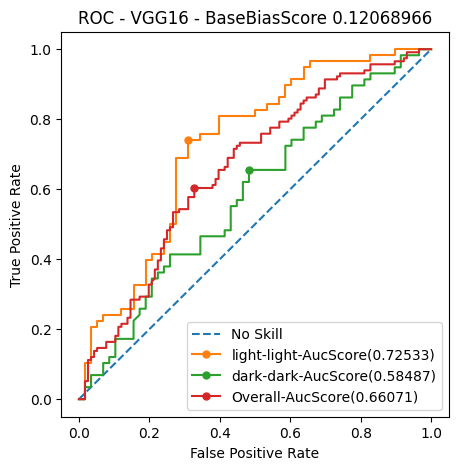

In [18]:
PredictionPlotKit.plot_roc(vgg16_prediction_result)

In [19]:
print(vgg19_prediction_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 50.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.526794365172924 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.678767835909631 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.206896551724138 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.137931034482759 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 28.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.528848210624833 |
+-------

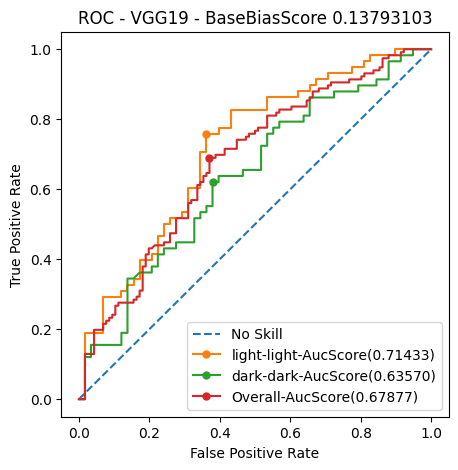

In [20]:
PredictionPlotKit.plot_roc(vgg19_prediction_result)

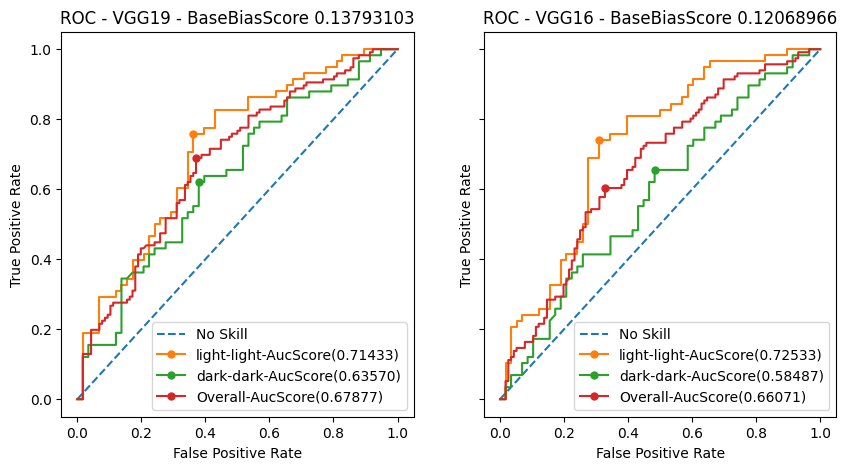

In [21]:
PredictionPlotKit.plot_multiple_roc(
    [
        vgg19_prediction_result,
        vgg16_prediction_result
    ]
)

In [22]:
from importlib.machinery import SourceFileLoader
resnet = SourceFileLoader("resnet","./resnet50_vggface/resnet.py").load_module()

weight_decay = 1e-4

# Code from https://github.com/WeidiXie/Keras-VGGFace2-ResNet50/tree/69a608a2a140b7025bcb69adcd2355e38cc89f1d
def Vggface2_ResNet50(input_dim=(224, 224, 3)):
    # inputs are of size 224 x 224 x 3
    inputs = keras.layers.Input(shape=input_dim, name='base_input')
    x = resnet.resnet50_backend(inputs)

    # AvgPooling
    x = keras.layers.AveragePooling2D((7, 7), name='avg_pool')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu', name='dim_proj')(x)
    y = keras.layers.Lambda(lambda x: keras.backend.l2_normalize(x, 1))(x)

    # Compile
    model = keras.models.Model(inputs=inputs, outputs=y, name='ResNet50')
    opt = Adam()
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    return model

path_to_weights = "./resnet50_vggface/weights.h5"
model_resnet = Vggface2_ResNet50()
model_resnet.load_weights(path_to_weights, by_name=True)

In [23]:
resnet_prediction_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = model_resnet,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [24]:
print(resnet_prediction_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 24.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.579471009172599 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.833865933412604 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.275862068965517 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.068965517241379 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 10.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.597616325545456 |
+-------

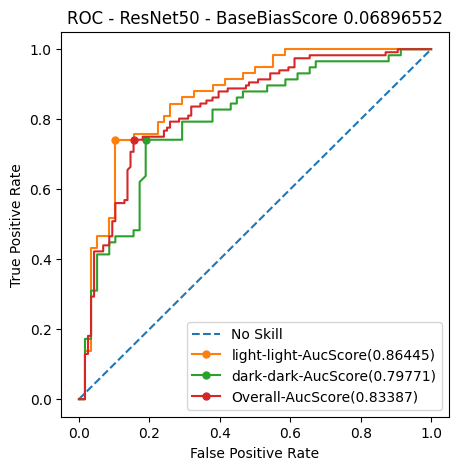

In [25]:
PredictionPlotKit.plot_roc(resnet_prediction_result)

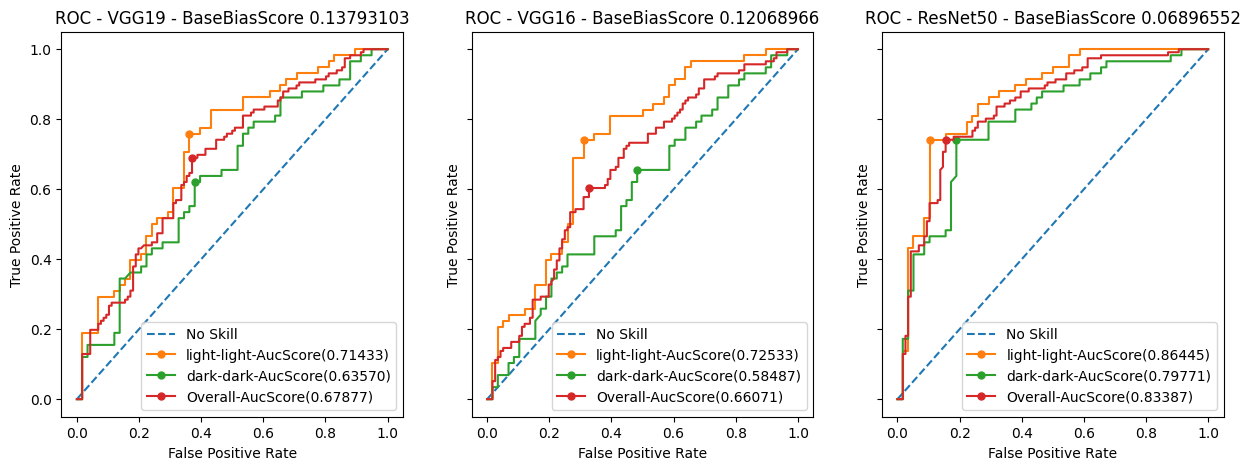

In [26]:
PredictionPlotKit.plot_multiple_roc(
    [
        vgg19_prediction_result,
        vgg16_prediction_result,
        resnet_prediction_result
    ]
)

In [27]:
def bpc(bias_score_model, bias_score_for_dibased_model):
    return (bias_score_model - bias_score_for_dibased_model)/bias_score_model

In [28]:
bpc(vgg16_prediction_result.get_base_bias_score(), vgg19_prediction_result.get_base_bias_score())

-0.14285714285714257

In [32]:
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from BiasStudy.predictionKit import GradCam
from matplotlib import pyplot as plt

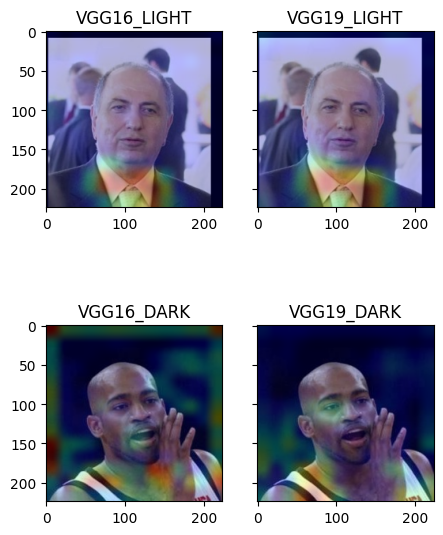

In [33]:
light_sample = all_pairs.loc[all_pairs['binary_race'] == 'light'].sample(1)
dark_sample = all_pairs.loc[all_pairs['binary_race'] == 'dark'].sample(1)

f, axs = plt.subplots(2, 2, sharey=True, figsize=(5,  7))

light_file_path = "{}/{}".format(IMAGE_DIR, light_sample.file_path.item())
dark_file_path = "{}/{}".format(IMAGE_DIR, dark_sample.file_path.item())
vgg16_last_conv_layer_name = "block5_conv3"
vgg19_last_conv_layer_name = "block5_conv4"

heatmap_16_light = GradCam.make_gradcam_heatmap(
    pre_processor_function = vgg16_preprocess_input,
    img_path = light_file_path, 
    model = vgg16_model, 
    last_conv_layer_name = vgg16_last_conv_layer_name
)

GradCam.save_and_display_gradcam(
    title = "VGG16_LIGHT",
    image_id = light_sample.image_id.item(),
    img_path = light_file_path,
    heatmap =  heatmap_16_light,
    ax = axs[0, 0]
)

heatmap_19_light = GradCam.make_gradcam_heatmap(
    pre_processor_function = vgg19_preprocess_input,
    img_path = light_file_path, 
    model = vgg19_model, 
    last_conv_layer_name = vgg19_last_conv_layer_name
)

GradCam.save_and_display_gradcam(
    title = "VGG19_LIGHT",
    image_id = light_sample.image_id.item(),
    img_path = light_file_path,
    heatmap =  heatmap_19_light,
    ax = axs[0, 1]
)

heatmap_16_dark = GradCam.make_gradcam_heatmap(
    pre_processor_function = vgg16_preprocess_input,
    img_path = dark_file_path, 
    model = vgg16_model, 
    last_conv_layer_name = vgg16_last_conv_layer_name
)

GradCam.save_and_display_gradcam(
    title = "VGG16_DARK",
    image_id = dark_sample.image_id.item(),
    img_path = dark_file_path,
    heatmap =  heatmap_16_dark,
    ax = axs[1, 0]
)

heatmap_19_dark = GradCam.make_gradcam_heatmap(
    pre_processor_function = vgg19_preprocess_input,
    img_path = dark_file_path, 
    model = vgg19_model, 
    last_conv_layer_name = vgg19_last_conv_layer_name
)

GradCam.save_and_display_gradcam(
    title = "VGG19_DARK",
    image_id = dark_sample.image_id.item(),
    img_path = dark_file_path,
    heatmap =  heatmap_19_dark,
    ax = axs[1, 1]
)

plt.show()
f.savefig("./output_images/heatmap.png", bbox_inches='tight')